In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as sc
import datetime as dt
import shapely as sh
import geopandas as gp
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist


plt.rcParams['figure.figsize'] = [16, 10]
%matplotlib inline


In [2]:
### Leveraging the POINT datatype of geopandas for tree data
publicTrees = gp.read_file('./Desktop/vancouverTrees/public-trees.geojson')
publicTrees.head()

,tree_id,civic_number,std_street,genus_name,species_name,cultivar_name,common_name,on_street_block,on_street,neighbourhood_name,street_side_name,height_range_id,height_range,diameter,date_planted,geo_point_2d,geometry
0,136658,2260,TRUTCH ST,STYRAX,JAPONICUS,None,JAPANESE SNOWBELL,2200,TRUTCH ST,KITSILANO,EVEN,2,20-30,7.0,1993-04-08,"{'lon': -123.17575399999873, 'lat': 49.2664209...",POINT (-123.17575 49.26642)
1,136660,2291,TRUTCH ST,ACER,FREEMANII X,SCARLET SENTINEL,FREEMAN'S S.S. MAPLE,2200,TRUTCH ST,KITSILANO,ODD,4,40-50,11.0,1993-04-08,"{'lon': -123.17591000023606, 'lat': 49.2660399...",POINT (-123.17591 49.26604)
2,136661,1095,BUTE ST,ACER,FREEMANII X,ARMSTRONG,ARMSTRONG RED MAPLE,1200,PENDRELL ST,WEST END,ODD,5,50-60,16.5,1993-04-13,"{'lon': -123.13260600034283, 'lat': 49.2827529...",POINT (-123.13261 49.28275)
3,136662,1095,BUTE ST,ACER,FREEMANII X,SCARLET SENTINEL,FREEMAN'S S.S. MAPLE,1200,PENDRELL ST,WEST END,ODD,4,40-50,19.0,1993-04-13,"{'lon': -123.13252299956686, 'lat': 49.2827029...",POINT (-123.13252 49.28270)
4,136665,1340,BURNABY ST,ACER,FREEMANII X,ARMSTRONG,ARMSTRONG RED MAPLE,1300,BURNABY ST,WEST END,EVEN,8,80-90,18.0,1993-04-05,"{'lon': -123.13666099944392, 'lat': 49.2824639...",POINT (-123.13666 49.28246)


In [3]:
### Importing Vancouver boundary file
vancouverBoundary = gp.read_file('./Desktop/vancouverTrees/local-area-boundary.geojson')
vancouverBoundary.head()

,name,geo_point_2d,geometry
0,Downtown,"{'lon': -123.11656700827415, 'lat': 49.2807470...","POLYGON ((-123.11227 49.29016, -123.10424 49.2..."
1,Hastings-Sunrise,"{'lon': -123.04026992328848, 'lat': 49.2779340...","POLYGON ((-123.05649 49.29349, -123.05190 49.2..."
2,Kerrisdale,"{'lon': -123.15957618168902, 'lat': 49.2236554...","POLYGON ((-123.17908 49.21556, -123.17564 49.2..."
3,Marpole,"{'lon': -123.1283816596551, 'lat': 49.21020746...","POLYGON ((-123.10696 49.20416, -123.11153 49.2..."
4,Oakridge,"{'lon': -123.12302460370566, 'lat': 49.2264031...","POLYGON ((-123.10562 49.23312, -123.10616 49.2..."


In [4]:
### Spatial join to identify tress in a city
publicTreesInVancouver = gp.sjoin(publicTrees, vancouverBoundary)
publicTreesInVancouver.head()

,tree_id,civic_number,std_street,genus_name,species_name,cultivar_name,common_name,on_street_block,on_street,neighbourhood_name,street_side_name,height_range_id,height_range,diameter,date_planted,geo_point_2d_left,geometry,index_right,name,geo_point_2d_right
0,136658,2260,TRUTCH ST,STYRAX,JAPONICUS,None,JAPANESE SNOWBELL,2200,TRUTCH ST,KITSILANO,EVEN,2,20-30,7.0,1993-04-08,"{'lon': -123.17575399999873, 'lat': 49.2664209...",POINT (-123.17575 49.26642),18,Kitsilano,"{'lon': -123.16329474017252, 'lat': 49.2675398..."
1,136660,2291,TRUTCH ST,ACER,FREEMANII X,SCARLET SENTINEL,FREEMAN'S S.S. MAPLE,2200,TRUTCH ST,KITSILANO,ODD,4,40-50,11.0,1993-04-08,"{'lon': -123.17591000023606, 'lat': 49.2660399...",POINT (-123.17591 49.26604),18,Kitsilano,"{'lon': -123.16329474017252, 'lat': 49.2675398..."
171,137620,2582,W 5TH AV,CORNUS,NUTTALLII,None,PACIFIC DOGWOOD,2500,W 5TH AV,KITSILANO,EVEN,3,30-40,30.0,None,"{'lon': -123.16417600057456, 'lat': 49.2673809...",POINT (-123.16418 49.26738),18,Kitsilano,"{'lon': -123.16329474017252, 'lat': 49.2675398..."
233,138079,2971,W 5TH AV,BETULA,PENDULA,None,EUROPEAN WHITE BIRCH,2900,W 5TH AV,KITSILANO,ODD,5,50-60,41.0,None,"{'lon': -123.17206000025725, 'lat': 49.2676299...",POINT (-123.17206 49.26763),18,Kitsilano,"{'lon': -123.16329474017252, 'lat': 49.2675398..."
323,138558,2706,POINT GREY ROAD,ACER,SPECIES,None,MAPLE SPECIES,1600,STEPHENS ST,KITSILANO,BIKE MED,2,20-30,8.0,2014-04-15,"{'lon': -123.16623300051864, 'lat': 49.2720809...",POINT (-123.16623 49.27208),18,Kitsilano,"{'lon': -123.16329474017252, 'lat': 49.2675398..."


In [5]:
### Make neighbourhood name lower
publicTreesInVancouver.neighbourhood_name = publicTreesInVancouver.neighbourhood_name.apply(lambda x: x.lower())
publicTreesInVancouver.name = publicTreesInVancouver.name.apply(lambda x: x.lower())

In [6]:
### Total records
publicTreesInVancouver.shape

(178022, 20)

In [7]:
### Mismatched records
publicTreesInVancouver[publicTreesInVancouver.neighbourhood_name != publicTreesInVancouver.name].shape

(60, 20)

In [8]:
### Groupby neighbourhood_name
neighbourhood = publicTreesInVancouver.groupby('name').count().reset_index().loc[:, ['name','tree_id']]
neighbourhood.head()

,name,tree_id
0,arbutus ridge,6199
1,downtown,7116
2,dunbar-southlands,9593
3,fairview,4698
4,grandview-woodland,6911


In [9]:
### VancouverBoundary join
vancouverBoundary.name = vancouverBoundary.name.apply(lambda x: x.lower())
vancouverBoundaryCount = pd.merge(vancouverBoundary, neighbourhood, on='name')
vancouverBoundaryCount.rename({'tree_id' : 'total_trees'}, axis = 1, inplace=True)
vancouverBoundaryCount.head()

,name,geo_point_2d,geometry,total_trees
0,downtown,"{'lon': -123.11656700827415, 'lat': 49.2807470...","POLYGON ((-123.11227 49.29016, -123.10424 49.2...",7116
1,hastings-sunrise,"{'lon': -123.04026992328848, 'lat': 49.2779340...","POLYGON ((-123.05649 49.29349, -123.05190 49.2...",13302
2,kerrisdale,"{'lon': -123.15957618168902, 'lat': 49.2236554...","POLYGON ((-123.17908 49.21556, -123.17564 49.2...",9711
3,marpole,"{'lon': -123.1283816596551, 'lat': 49.21020746...","POLYGON ((-123.10696 49.20416, -123.11153 49.2...",7676
4,oakridge,"{'lon': -123.12302460370566, 'lat': 49.2264031...","POLYGON ((-123.10562 49.23312, -123.10616 49.2...",7167


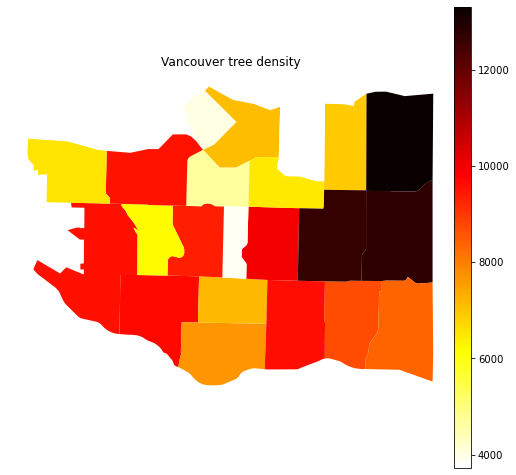

In [10]:
### Vancouver tree density
vmin, vmax = vancouverBoundaryCount.total_trees.min(), vancouverBoundaryCount.total_trees.max()

ax = vancouverBoundaryCount.plot(column='total_trees', colormap='hot_r', vmin=vmin, vmax=vmax, linewidth = 0.1, alpha = 1, figsize=(8,8))
ax.set_axis_off()
ax.set_title('Vancouver tree density')
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.show()